In [ ]:
!pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 6.6 MB/s 


In [ ]:
from glob import glob
from sklearn.model_selection import GroupKFold, StratifiedKFold
import cv2
from skimage import io
import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
from tqdm import tqdm
from IPython.display import display
import matplotlib.pyplot as plt
import sklearn
import warnings
import joblib
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import warnings; warnings.filterwarnings('ignore')
import cv2
import pydicom
#from efficientnet_pytorch import EfficientNet
from scipy.ndimage.interpolation import zoom

import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score

from pylab import rcParams
rcParams['figure.figsize'] = 20,5

In [3]:
!gdown --id 1diztKyKFfhINpY-8R_KB84kV8akW2NjD

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1diztKyKFfhINpY-8R_KB84kV8akW2NjD
To: /content/test_train_val.zip
100% 480M/480M [00:01<00:00, 286MB/s]


In [ ]:
!unzip -qq test_train_val.zip

In [ ]:
with open('test_train_val/train_meta.csv') as f:
  train_df= pd.read_csv(f)
with open('test_train_val/train_signal.csv') as f:
  train_signal = pd.read_csv(f)

with open('test_train_val/valid_meta.csv') as f:
  valid_df= pd.read_csv(f)
with open('test_train_val/valid_signal.csv') as f:
  valid_signal = pd.read_csv(f)

with open('test_train_val/test_meta.csv') as f:
  test_df= pd.read_csv(f)
with open('test_train_val/test_signal.csv') as f:
  test_signal = pd.read_csv(f)

print(train_df.shape)

train_df

(17441, 37)


,ecg_id,age,sex,height,weight,nurse,site,device,NORM,MI,...,sub_ISC_,sub_SEHYP,sub_ISCI,sub_CRBBB,sub_CLBBB,sub_LAO/LAE,sub_ILBBB,sub_WPW,sub_PMI,strat_fold
0,1,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1,0,...,0,0,0,0,0,0,0,0,0,3
1,2,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1,0,...,0,0,0,0,0,0,0,0,0,2
2,3,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1,0,...,0,0,0,0,0,0,0,0,0,5
3,4,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1,0,...,0,0,0,0,0,0,0,0,0,3
4,5,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1,0,...,0,0,0,0,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17436,21832,63.0,0,NaN,NaN,1.0,2.0,AT-60 3,0,0,...,0,0,0,0,0,0,0,0,0,7
17437,21833,67.0,1,NaN,NaN,1.0,2.0,AT-60 3,0,0,...,0,0,0,0,0,0,0,0,0,7
17438,21834,93.0,0,NaN,NaN,1.0,2.0,AT-60 3,1,0,...,0,0,0,0,0,0,0,0,0,4
17439,21835,59.0,1,NaN,NaN,1.0,2.0,AT-60 3,0,0,...,0,0,0,0,0,0,0,0,0,2


In [ ]:
class PTBXLDatasetPreprocesser():
    def __init__(self):
        pass
    
    def save(self, filename):
        data = {
            'superclass_cols': self.superclass_cols,
            'subclass_cols': self.subclass_cols,
            'meta_num_cols': self.meta_num_cols,
            'meta_num_means': self.meta_num_means,
            'min_max_scaler': self.min_max_scaler,
            'meta_cat_cols': self.meta_cat_cols,
            'cat_lablers': self.cat_lablers,
            'bclass_cols': self.bclass_cols,
            
        }
        pd.to_pickle(data, filename)
        
    def load(self, filename):
        data = pd.read_pickle(filename)
        self.min_max_scaler = data['min_max_scaler']
        self.cat_lablers = data['cat_lablers']
        #self.binary_lablers = data['binary_lablers']
        
    def fit(self, x, y):
        x = x.copy()
        y = y.copy()
        
        self.superclass_cols = [ 'MI', 'STTC', 'CD', 'HYP']
        
        self.subclass_cols = [col for col in y.columns if 'sub_' in col]

        self.bclass_cols = ['NORM']
        
        self.meta_num_cols = ['age', 'height', 'weight']
        self.meta_num_means = []
        for col in self.meta_num_cols:
            print(col, y[col].mean())
            y[col] = y[col].fillna(y[col].mean())
            self.meta_num_means += [y[col].mean()]
            
        self.min_max_scaler = MinMaxScaler().fit(y[self.meta_num_cols])
        
        self.meta_cat_cols = ['sex'] #, 'nurse', 'device']
        self.cat_lablers = [LabelEncoder().fit(y[col].fillna('none').astype(str)) for col in self.meta_cat_cols]
        return self

        #self.min_max_scaler = MinMaxScaler().fit(y[self.meta_num_cols])
        
        #self.meta_binary_cols = ['NORM'] 
        #self.binary_lablers = [LabelEncoder().fit(y[col].fillna('none').astype(str)) for col in self.meta_binary_cols]
        #return self
    
    def transform(self, x, y):
        
        channel_cols = x.columns.tolist()[1:]
        
        ret = []
        x = x[channel_cols].values.reshape(-1, 1000, 12)
        print(x.shape)
        ret += [x] # signal
        
        y_ = y.copy()
        
        for i, col in enumerate(self.meta_num_cols):
            y_[col] = y_[col].fillna(self.meta_num_means[i])
        y_[self.meta_num_cols] = self.min_max_scaler.transform(y_[self.meta_num_cols])
        y_[self.meta_num_cols] = np.clip(y_[self.meta_num_cols], 0., 1.) # prevent extreme value far from train set
        
        ret += [y_[self.meta_num_cols]] # meta num features
        
        for i, col in enumerate(self.meta_cat_cols):
            y_[col] = y_[col].fillna('none').astype(str)
            y_[col] = self.cat_lablers[i].transform(y_[col]) 
        
        ret += [y_[self.meta_cat_cols]] # meta cat features

        #for i, col in enumerate(self.meta_binary_cols):
           # y_[col] = y_[col].fillna('none').astype(str)
           # y_[col] = self.binary_lablers[i].transform(y_[col]) 
        
        #ret += [y_[self.meta_binary_cols]] # binary class target
        
        if np.isin(self.superclass_cols, y.columns).sum() == len(self.superclass_cols):
            ret += [y[self.superclass_cols].fillna(0).astype(int)] # superclass targets
        
        if np.isin(self.subclass_cols, y.columns).sum() == len(self.subclass_cols):
            ret += [y[self.subclass_cols].fillna(0).astype(int)] # subclass targets

        if np.isin(self.bclass_cols, y.columns).sum() == len(self.bclass_cols):
            ret += [y[self.bclass_cols].fillna(0).astype(int)]
        
        return ret

In [ ]:
data_preprocessor = PTBXLDatasetPreprocesser()
data_preprocessor.fit(train_signal, train_df)
train_signal, train_meta_num_feats, train_meta_cat_feats, train_superclass, train_subclass, train_bclass = data_preprocessor.transform(train_signal, train_df)
valid_signal, valid_meta_num_feats, valid_meta_cat_feats, valid_superclass, valid_subclass, valid_bclass = data_preprocessor.transform(valid_signal, valid_df)
test_signal, test_meta_num_feats, test_meta_cat_feats, test_superclass, test_subclass, test_bclass = data_preprocessor.transform(test_signal, test_df)

print(train_signal.shape)
print(valid_meta_num_feats.isna().sum(), valid_meta_cat_feats.isna().sum(), valid_superclass.isna().sum(), valid_subclass.isna().sum(), valid_bclass.isna().sum())

display(train_meta_num_feats)
display(train_meta_cat_feats)
display(train_superclass)
display(train_subclass)
display(train_bclass)

age 59.63709074169975
height 166.68908469699693
weight 70.69599447513812
(17441, 1000, 12)
(2193, 1000, 12)
(2203, 1000, 12)
(17441, 1000, 12)
age       0
height    0
weight    0
dtype: int64 sex    0
dtype: int64 MI      0
STTC    0
CD      0
HYP     0
dtype: int64 sub_NORM         0
sub_IMI          0
sub_STTC         0
sub_NST_         0
sub_LVH          0
sub_LAFB/LPFB    0
sub_RVH          0
sub_RAO/RAE      0
sub_IRBBB        0
sub_IVCD         0
sub_LMI          0
sub_AMI          0
sub__AVB         0
sub_ISCA         0
sub_ISC_         0
sub_SEHYP        0
sub_ISCI         0
sub_CRBBB        0
sub_CLBBB        0
sub_LAO/LAE      0
sub_ILBBB        0
sub_WPW          0
sub_PMI          0
dtype: int64 NORM    0
dtype: int64


,age,height,weight
0,0.580645,0.791572,0.282927
1,0.182796,0.791572,0.317073
2,0.376344,0.791572,0.312195
3,0.236559,0.791572,0.375610
4,0.182796,0.791572,0.317073
...,...,...,...
17436,0.655914,0.791572,0.320468
17437,0.698925,0.791572,0.320468
17438,0.978495,0.791572,0.320468
17439,0.612903,0.791572,0.320468


,sex
0,1
1,0
2,1
3,0
4,1
...,...
17436,0
17437,1
17438,0
17439,1


,MI,STTC,CD,HYP
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0
...,...,...,...,...
17436,0,0,1,0
17437,0,1,0,0
17438,0,0,0,0
17439,0,1,0,0


,sub_NORM,sub_IMI,sub_STTC,sub_NST_,sub_LVH,sub_LAFB/LPFB,sub_RVH,sub_RAO/RAE,sub_IRBBB,sub_IVCD,...,sub_ISCA,sub_ISC_,sub_SEHYP,sub_ISCI,sub_CRBBB,sub_CLBBB,sub_LAO/LAE,sub_ILBBB,sub_WPW,sub_PMI
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17436,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
17437,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17438,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17439,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


,NORM
0,1
1,1
2,1
3,1
4,1
...,...
17436,0
17437,0
17438,1
17439,0


In [ ]:
new_df= np.hstack((train_meta_num_feats, train_meta_cat_feats))
new_df.shape

(17441, 4)

In [ ]:
df=new_df.reshape(-1,1,4)

In [ ]:
#signal=np.array(train_signal)
#signal.shape
#print(signal)

In [ ]:
#newsignal= signal.reshape(17441,10,100,12)


In [ ]:
target=np.array(train_bclass)
target.shape

(17441, 1)

In [ ]:
tar=target.reshape(-1,1)

In [ ]:
#v_signal=np.array(valid_signal)

In [ ]:
#v_signal.shape

In [ ]:
#newv_signal=v_signal.reshape(2193,10,100,12)

In [ ]:
new_valid= np.hstack((valid_meta_num_feats, valid_meta_cat_feats))
new_valid.shape

(2193, 4)

In [ ]:
val=new_valid.reshape(-1,1,4)

In [ ]:
v_target=np.array(valid_bclass)
v_target.shape

(2193, 1)

In [ ]:
v_tar=v_target.reshape(-1,1)

In [ ]:
!pip install ecg-plot
#import physionet_challenge_utility_script as pc
import ecg_plot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model
#from keras.utils import plot_model
from keras.preprocessing.sequence import pad_sequences
from keras import layers
from keras.layers import Input, Dense, Dropout, Activation, BatchNormalization, Add
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPool1D, ZeroPadding1D, LSTM, Bidirectional, ConvLSTM1D
from keras.models import Sequential, Model
#from keras.utils import plot_model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.layers.merge import concatenate
from scipy import optimize
from scipy.io import loadmat
import os
%load_ext autoreload
%autoreload
%reload_ext autoreload

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Binary Classification on ECG ataset**

**ANN MODEL**

In [ ]:
ann_model = Sequential()
ann_model.add(Dense(50, activation='relu', input_shape=(1,4)))
ann_model.add(Dense(50, activation='relu'))
ann_model.add(Dense(50, activation='relu'))
ann_model.add(Dense(50, activation='relu'))
ann_model.add(GlobalAveragePooling1D())
ann_model.add(Dense(1, activation='sigmoid'))

In [ ]:
ann_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])

In [ ]:
ann_model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_71 (Dense)            (None, 1, 50)             250       
                                                                 
 dense_72 (Dense)            (None, 1, 50)             2550      
                                                                 
 dense_73 (Dense)            (None, 1, 50)             2550      
                                                                 
 dense_74 (Dense)            (None, 1, 50)             2550      
                                                                 
 global_average_pooling1d_17  (None, 50)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_75 (Dense)            (None, 1)                 51        
                                                     

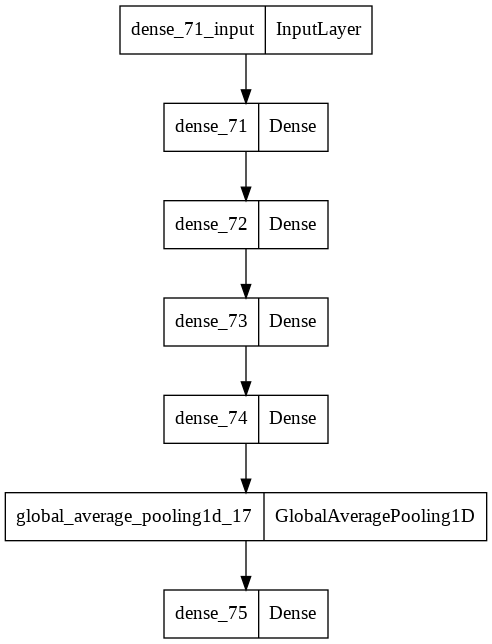

In [ ]:
plot_model(ann_model)

In [ ]:
batchsize = 16
ann_model.fit(x=df, y=tar, batch_size=batchsize, epochs=50, verbose='auto', callbacks=None,  validation_data=(val,v_tar), shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None)

Epoch 1/50
1091/1091 [==============================] - 9s 8ms/step - loss: 0.5939 - accuracy: 0.6959 - Recall: 0.5064 - Precision: 0.7132 - AUC: 0.7293 - val_loss: 0.5819 - val_accuracy: 0.6945 - val_Recall: 0.4577 - val_Precision: 0.7436 - val_AUC: 0.7670
Epoch 2/50
1091/1091 [==============================] - 7s 6ms/step - loss: 0.5931 - accuracy: 0.6982 - Recall: 0.5103 - Precision: 0.7161 - AUC: 0.7306 - val_loss: 0.5786 - val_accuracy: 0.6954 - val_Recall: 0.5653 - val_Precision: 0.6822 - val_AUC: 0.7690
Epoch 3/50
1091/1091 [==============================] - 7s 6ms/step - loss: 0.5926 - accuracy: 0.6957 - Recall: 0.5044 - Precision: 0.7139 - AUC: 0.7317 - val_loss: 0.5756 - val_accuracy: 0.6959 - val_Recall: 0.5204 - val_Precision: 0.7054 - val_AUC: 0.7723
Epoch 4/50
1091/1091 [==============================] - 7s 6ms/step - loss: 0.5930 - accuracy: 0.6951 - Recall: 0.5031 - Precision: 0.7133 - AUC: 0.7310 - val_loss: 0.5767 - val_accuracy: 0.6899 - val_Recall: 0.5361 - val_Prec

Text(0, 0.5, 'Accuracy')

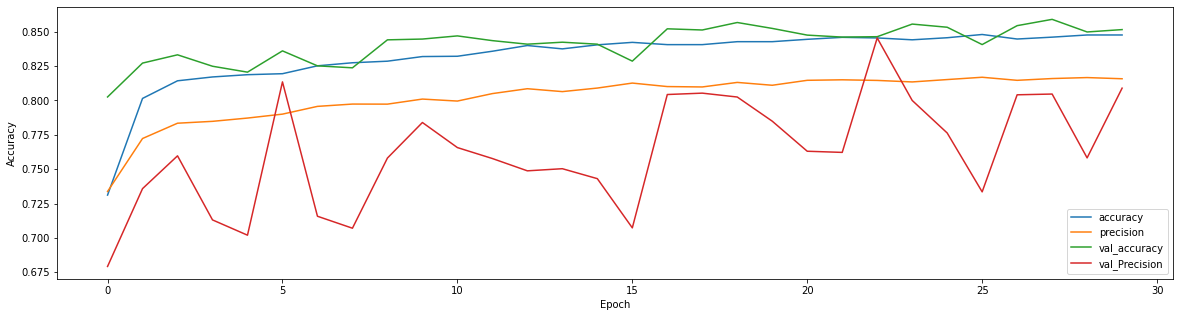

In [ ]:
plt.plot(ann_model.history.history['accuracy'])
plt.plot(ann_model.history.history['Precision'])
plt.plot(ann_model.history.history['val_accuracy'])
plt.plot(ann_model.history.history['val_Precision'])
plt.legend(("accuracy","precision","val_accuracy","val_Precision"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

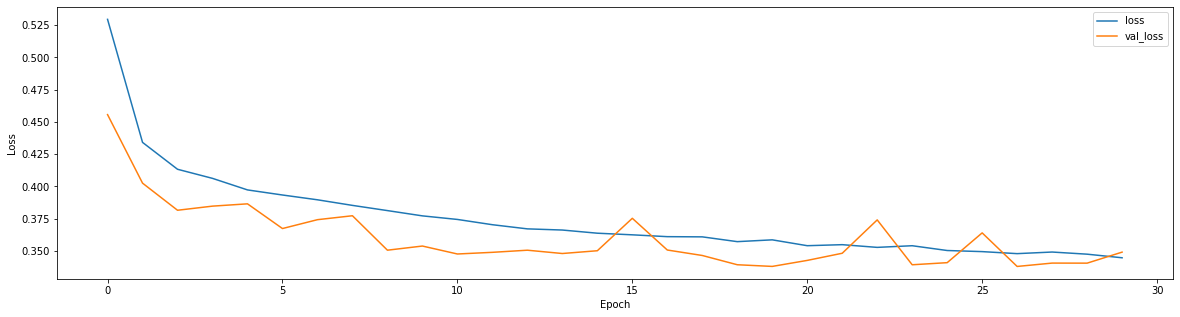

In [ ]:
plt.plot(ann_model.history.history['loss'])
plt.plot(ann_model.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0.5, 0, 'Epoch')

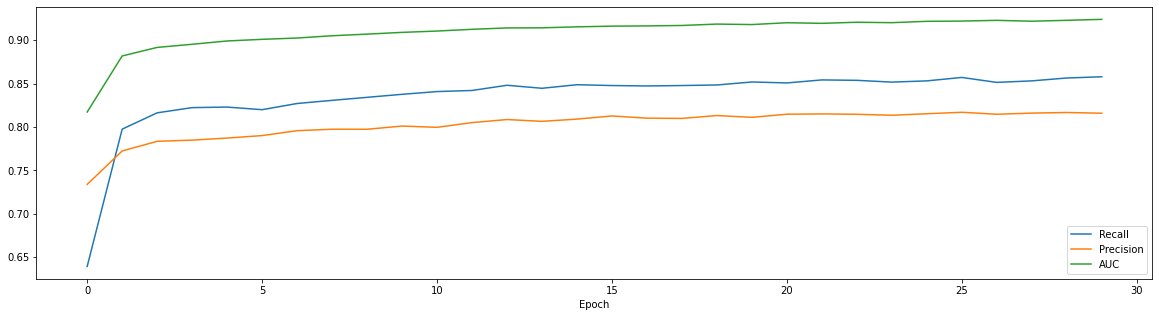

In [ ]:
plt.plot(ann_model.history.history['Recall'])
plt.plot(ann_model.history.history['Precision'])
plt.plot(ann_model.history.history['AUC'])
plt.legend(("Recall","Precision","AUC"))
plt.xlabel('Epoch')

**CNN MODEL**

**Lenet-5 model**

In [ ]:
lenet_5_model=Sequential()

lenet_5_model.add(Conv1D(filters=3, kernel_size=2, padding='same', input_shape=(1,4)))
lenet_5_model.add(BatchNormalization())
lenet_5_model.add(Activation('relu'))
lenet_5_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

lenet_5_model.add(Conv1D(filters=3, strides=1, kernel_size=2))
lenet_5_model.add(BatchNormalization())
lenet_5_model.add(Activation('relu'))
lenet_5_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

lenet_5_model.add(GlobalAveragePooling1D())

lenet_5_model.add(Dense(64, activation='relu'))

lenet_5_model.add(Dense(32, activation='relu'))

lenet_5_model.add(Dense(1, activation = 'sigmoid'))

ValueError: ignored

In [ ]:
lenet_5_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])

In [ ]:
lenet_5_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1000, 6)           222       
                                                                 
 batch_normalization (BatchN  (None, 1000, 6)          24        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 1000, 6)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 500, 6)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 496, 16)           496       
                                                                 
 batch_normalization_1 (Batc  (None, 496, 16)         

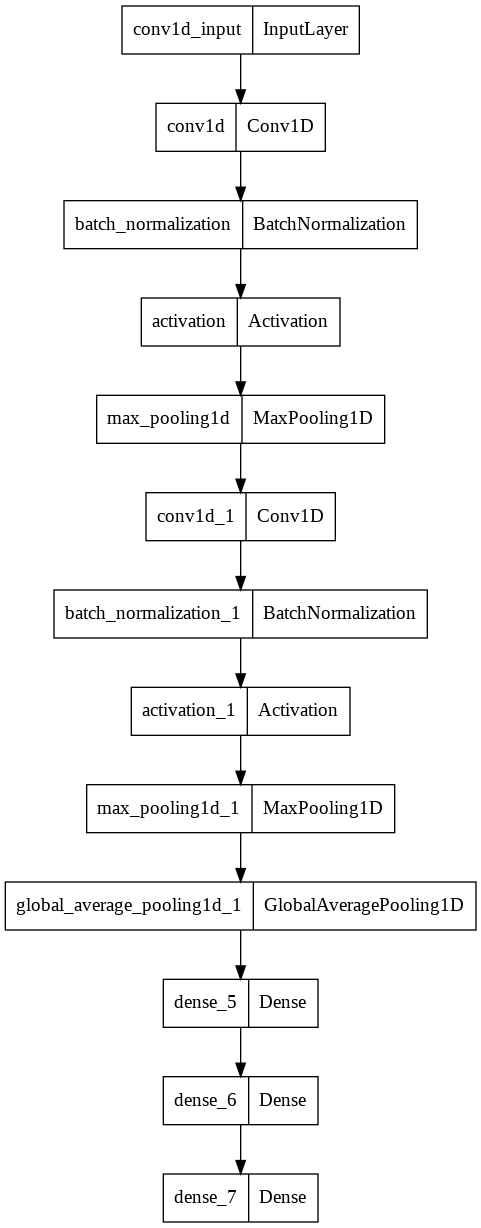

In [ ]:
plot_model(lenet_5_model)

In [ ]:
batchsize = 16
lenet_5_model.fit(x=df, y=tar, batch_size=batchsize, epochs=30, verbose='auto', callbacks=None, validation_split=0.2, validation_data=(val,v_tar), shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None)

Epoch 1/30
872/872 [==============================] - 17s 8ms/step - loss: 0.5057 - accuracy: 0.7484 - Recall: 0.6998 - Precision: 0.7333 - AUC: 0.8290 - val_loss: 0.3982 - val_accuracy: 0.8223 - val_Recall: 0.7887 - val_Precision: 0.7423 - val_AUC: 0.8974
Epoch 2/30
872/872 [==============================] - 6s 7ms/step - loss: 0.4321 - accuracy: 0.7996 - Recall: 0.7987 - Precision: 0.7686 - AUC: 0.8783 - val_loss: 0.3863 - val_accuracy: 0.8277 - val_Recall: 0.6808 - val_Precision: 0.8184 - val_AUC: 0.9094
Epoch 3/30
872/872 [==============================] - 6s 7ms/step - loss: 0.4118 - accuracy: 0.8070 - Recall: 0.8120 - Precision: 0.7737 - AUC: 0.8898 - val_loss: 0.3835 - val_accuracy: 0.8283 - val_Recall: 0.6800 - val_Precision: 0.8206 - val_AUC: 0.9114
Epoch 4/30
872/872 [==============================] - 6s 7ms/step - loss: 0.3973 - accuracy: 0.8159 - Recall: 0.8192 - Precision: 0.7844 - AUC: 0.8983 - val_loss: 0.3913 - val_accuracy: 0.8117 - val_Recall: 0.8983 - val_Precision: 

Text(0, 0.5, 'Accuracy')

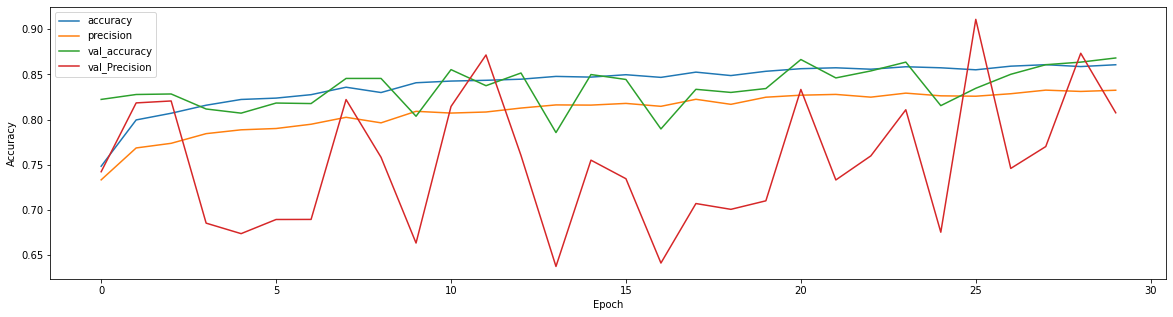

In [ ]:
plt.plot(lenet_5_model.history.history['accuracy'])
plt.plot(lenet_5_model.history.history['Precision'])
plt.plot(lenet_5_model.history.history['val_accuracy'])
plt.plot(lenet_5_model.history.history['val_Precision'])
plt.legend(("accuracy","precision","val_accuracy","val_Precision"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

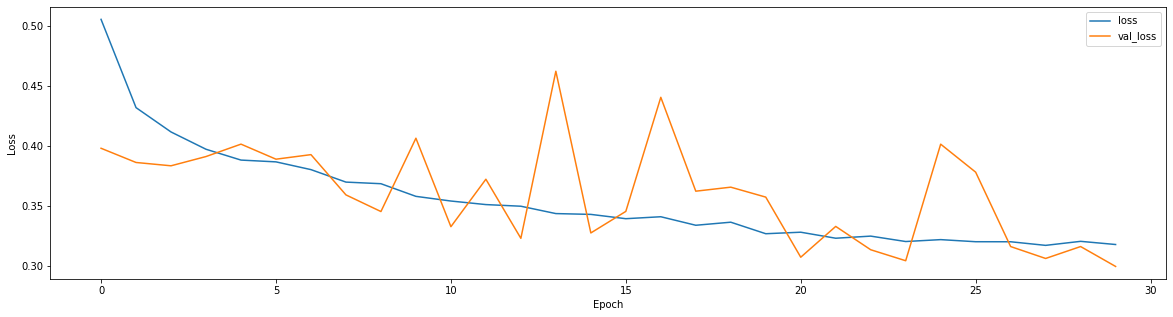

In [ ]:
plt.plot(lenet_5_model.history.history['loss'])
plt.plot(lenet_5_model.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0.5, 0, 'Epoch')

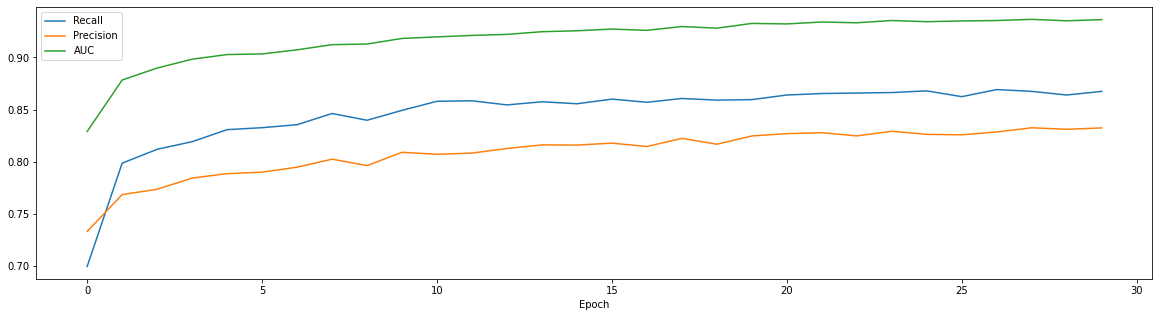

In [ ]:
plt.plot(lenet_5_model.history.history['Recall'])
plt.plot(lenet_5_model.history.history['Precision'])
plt.plot(lenet_5_model.history.history['AUC'])
plt.legend(("Recall","Precision","AUC"))
plt.xlabel('Epoch')

**AlexNet model**

In [ ]:
alexNet_model=Sequential()

alexNet_model.add(Conv1D(filters=96, kernel_size=11, strides=4, input_shape=(1000,12)))
alexNet_model.add(BatchNormalization())
alexNet_model.add(Activation('relu'))
alexNet_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

alexNet_model.add(Conv1D(filters=256, kernel_size=5, padding='same'))
alexNet_model.add(BatchNormalization())
alexNet_model.add(Activation('relu'))
alexNet_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

alexNet_model.add(Conv1D(filters=384, padding='same', kernel_size=3))
alexNet_model.add(BatchNormalization())
alexNet_model.add(Activation('relu'))
alexNet_model.add(Conv1D(filters=384, kernel_size=3))
alexNet_model.add(BatchNormalization())
alexNet_model.add(Activation('relu'))
alexNet_model.add(Conv1D(filters=256, kernel_size=3))
alexNet_model.add(BatchNormalization())
alexNet_model.add(Activation('relu'))
alexNet_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

alexNet_model.add(GlobalAveragePooling1D())
alexNet_model.add(Dense(128, activation='relu'))
alexNet_model.add(Dropout(0.4))
alexNet_model.add(Dense(128, activation='relu'))
alexNet_model.add(Dropout(0.4))
alexNet_model.add(Dense(1, activation='sigmoid'))

In [ ]:
alexNet_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])

In [ ]:
alexNet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 248, 96)           12768     
                                                                 
 batch_normalization_2 (Batc  (None, 248, 96)          384       
 hNormalization)                                                 
                                                                 
 activation_2 (Activation)   (None, 248, 96)           0         
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 124, 96)          0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 124, 256)          123136    
                                                                 
 batch_normalization_3 (Batc  (None, 124, 256)        

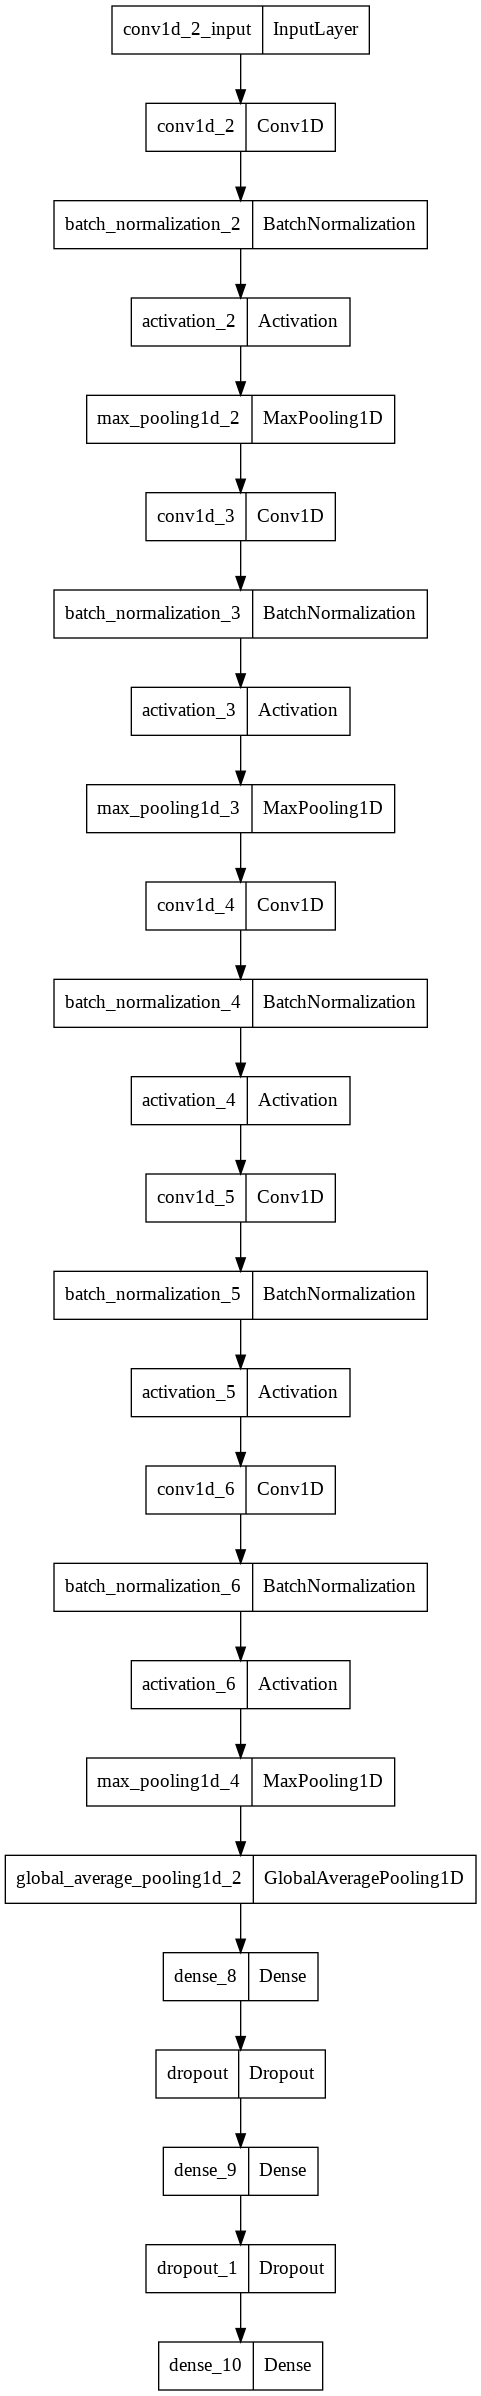

In [ ]:
plot_model(alexNet_model)

In [ ]:
batchsize = 16
alexNet_model.fit(x=signal, y=target, batch_size=batchsize, epochs=30, verbose='auto', callbacks=None, validation_split=0.2, validation_data=(v_signal,v_target), shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None)

Epoch 1/30
872/872 [==============================] - 14s 12ms/step - loss: 0.4041 - accuracy: 0.8252 - Recall: 0.8380 - Precision: 0.7895 - AUC: 0.8978 - val_loss: 0.3314 - val_accuracy: 0.8573 - val_Recall: 0.7512 - val_Precision: 0.8421 - val_AUC: 0.9361
Epoch 2/30
872/872 [==============================] - 10s 11ms/step - loss: 0.3491 - accuracy: 0.8513 - Recall: 0.8635 - Precision: 0.8186 - AUC: 0.9238 - val_loss: 0.2933 - val_accuracy: 0.8667 - val_Recall: 0.8568 - val_Precision: 0.7952 - val_AUC: 0.9436
Epoch 3/30
872/872 [==============================] - 10s 11ms/step - loss: 0.3354 - accuracy: 0.8605 - Recall: 0.8714 - Precision: 0.8296 - AUC: 0.9293 - val_loss: 0.3400 - val_accuracy: 0.8573 - val_Recall: 0.6933 - val_Precision: 0.8931 - val_AUC: 0.9439
Epoch 4/30
872/872 [==============================] - 10s 11ms/step - loss: 0.3198 - accuracy: 0.8638 - Recall: 0.8820 - Precision: 0.8288 - AUC: 0.9357 - val_loss: 0.2935 - val_accuracy: 0.8673 - val_Recall: 0.8732 - val_Prec

Text(0, 0.5, 'Accuracy')

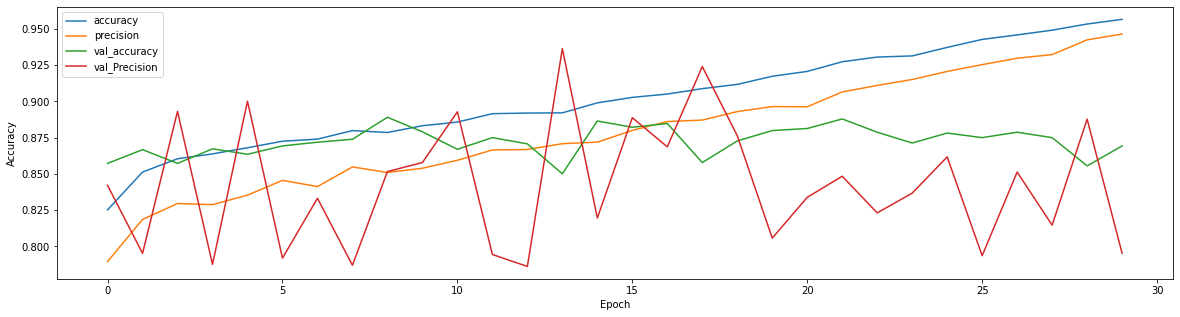

In [ ]:
plt.plot(alexNet_model.history.history['accuracy'])
plt.plot(alexNet_model.history.history['Precision'])
plt.plot(alexNet_model.history.history['val_accuracy'])
plt.plot(alexNet_model.history.history['val_Precision'])
plt.legend(("accuracy","precision","val_accuracy","val_Precision"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

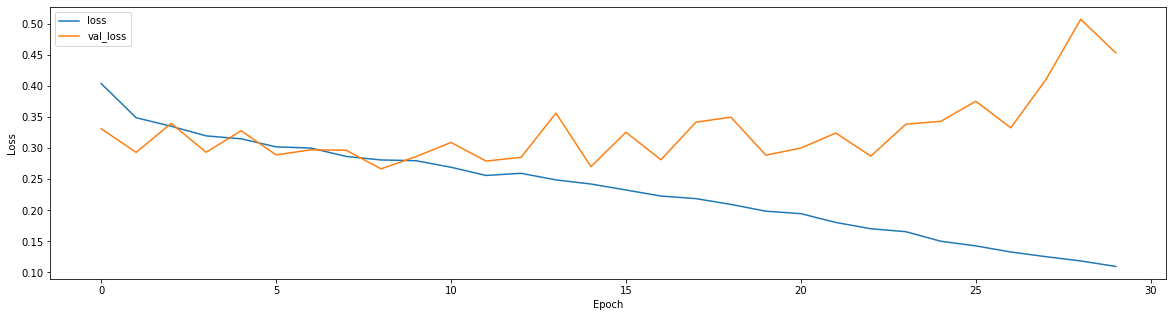

In [ ]:
plt.plot(alexNet_model.history.history['loss'])
plt.plot(alexNet_model.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0.5, 0, 'Epoch')

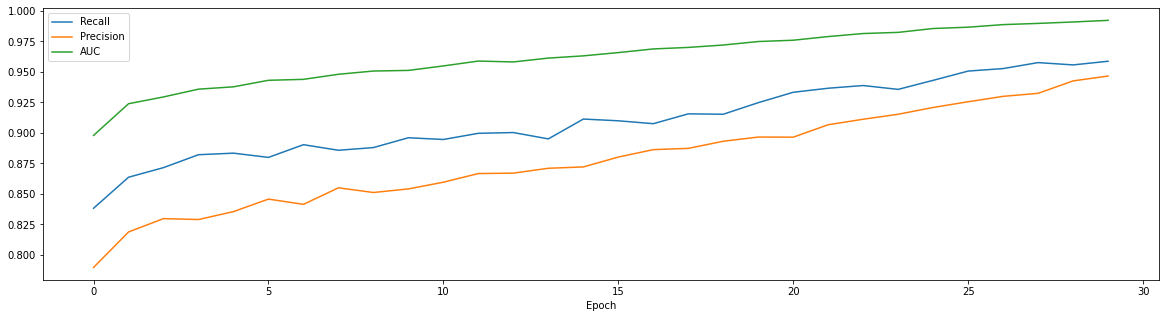

In [ ]:
plt.plot(alexNet_model.history.history['Recall'])
plt.plot(alexNet_model.history.history['Precision'])
plt.plot(alexNet_model.history.history['AUC'])
plt.legend(("Recall","Precision","AUC"))
plt.xlabel('Epoch')

**VGG 16**

In [ ]:
vgg_16_model=Sequential()

vgg_16_model.add(Conv1D(filters=64, kernel_size=3, padding='same',  input_shape=(1000,12)))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(Conv1D(filters=64, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

vgg_16_model.add(Conv1D(filters=128, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(Conv1D(filters=128, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

vgg_16_model.add(Conv1D(filters=256, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(Conv1D(filters=256, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(Conv1D(filters=256, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

vgg_16_model.add(Conv1D(filters=512, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(Conv1D(filters=512, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(Conv1D(filters=512, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

vgg_16_model.add(Conv1D(filters=512, kernel_size=3, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(Conv1D(filters=512, kernel_size=1, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(Conv1D(filters=512, kernel_size=1, padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Activation('relu'))
vgg_16_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

vgg_16_model.add(GlobalAveragePooling1D())
vgg_16_model.add(Dense(256, activation='relu'))
vgg_16_model.add(Dropout(0.4))
vgg_16_model.add(Dense(128, activation='relu'))
vgg_16_model.add(Dropout(0.4))
vgg_16_model.add(Dense(1, activation='sigmoid'))

In [ ]:
 vgg_16_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])

In [ ]:
vgg_16_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 1000, 64)          2368      
                                                                 
 batch_normalization_7 (Batc  (None, 1000, 64)         256       
 hNormalization)                                                 
                                                                 
 activation_7 (Activation)   (None, 1000, 64)          0         
                                                                 
 conv1d_8 (Conv1D)           (None, 1000, 64)          12352     
                                                                 
 batch_normalization_8 (Batc  (None, 1000, 64)         256       
 hNormalization)                                                 
                                                                 
 activation_8 (Activation)   (None, 1000, 64)         

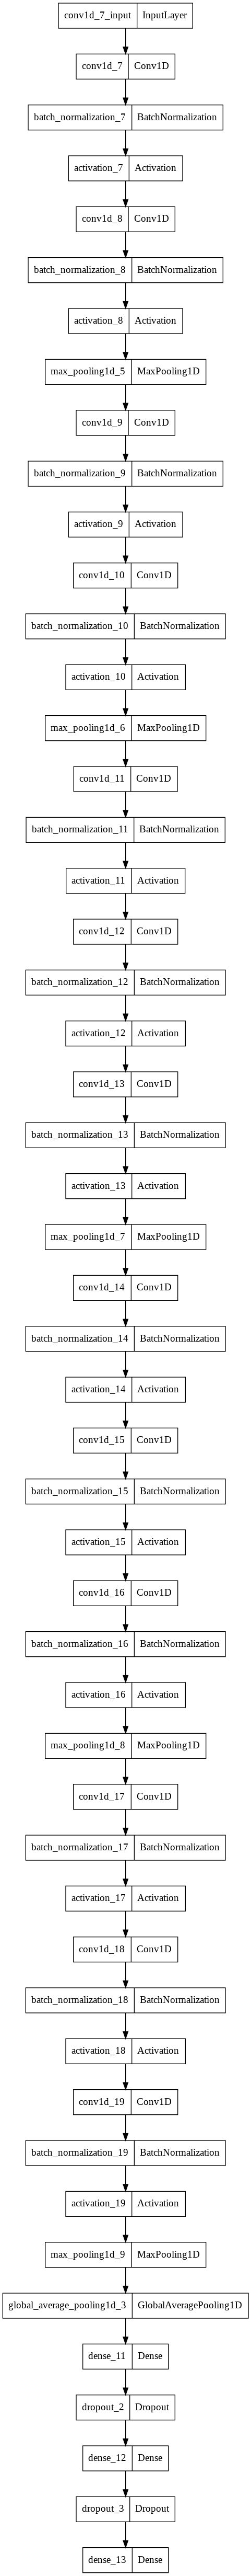

In [ ]:
plot_model(vgg_16_model)

In [ ]:
batchsize = 16
vgg_16_model.fit(x=signal, y=target, batch_size=batchsize, epochs=30, verbose='auto', callbacks=None, validation_split=0.2, validation_data=(v_signal,v_target), shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None)

Epoch 1/30
872/872 [==============================] - 37s 37ms/step - loss: 0.4433 - accuracy: 0.8048 - Recall: 0.8161 - Precision: 0.7680 - AUC: 0.8783 - val_loss: 0.3793 - val_accuracy: 0.8358 - val_Recall: 0.8654 - val_Precision: 0.7339 - val_AUC: 0.9238
Epoch 2/30
872/872 [==============================] - 31s 36ms/step - loss: 0.3823 - accuracy: 0.8402 - Recall: 0.8580 - Precision: 0.8031 - AUC: 0.9095 - val_loss: 0.3233 - val_accuracy: 0.8535 - val_Recall: 0.8850 - val_Precision: 0.7565 - val_AUC: 0.9339
Epoch 3/30
872/872 [==============================] - 31s 36ms/step - loss: 0.3573 - accuracy: 0.8497 - Recall: 0.8679 - Precision: 0.8133 - AUC: 0.9209 - val_loss: 0.3057 - val_accuracy: 0.8696 - val_Recall: 0.7559 - val_Precision: 0.8711 - val_AUC: 0.9465
Epoch 4/30
872/872 [==============================] - 31s 36ms/step - loss: 0.3393 - accuracy: 0.8612 - Recall: 0.8780 - Precision: 0.8268 - AUC: 0.9280 - val_loss: 0.3207 - val_accuracy: 0.8610 - val_Recall: 0.9280 - val_Prec

Text(0, 0.5, 'Accuracy')

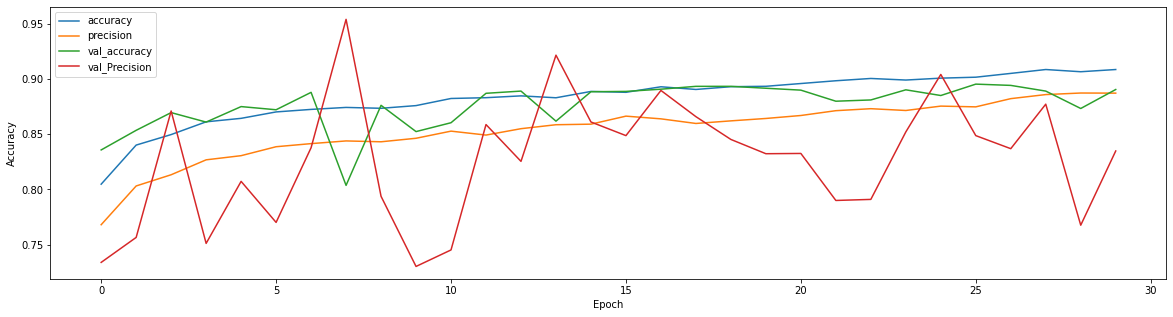

In [ ]:
plt.plot(vgg_16_model.history.history['accuracy'])
plt.plot(vgg_16_model.history.history['Precision'])
plt.plot(vgg_16_model.history.history['val_accuracy'])
plt.plot(vgg_16_model.history.history['val_Precision'])
plt.legend(("accuracy","precision","val_accuracy","val_Precision"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

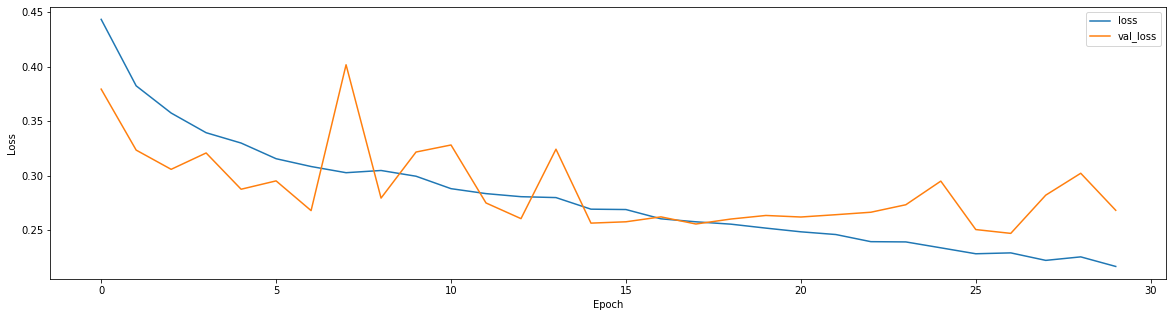

In [ ]:
plt.plot(vgg_16_model.history.history['loss'])
plt.plot(vgg_16_model.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0.5, 0, 'Epoch')

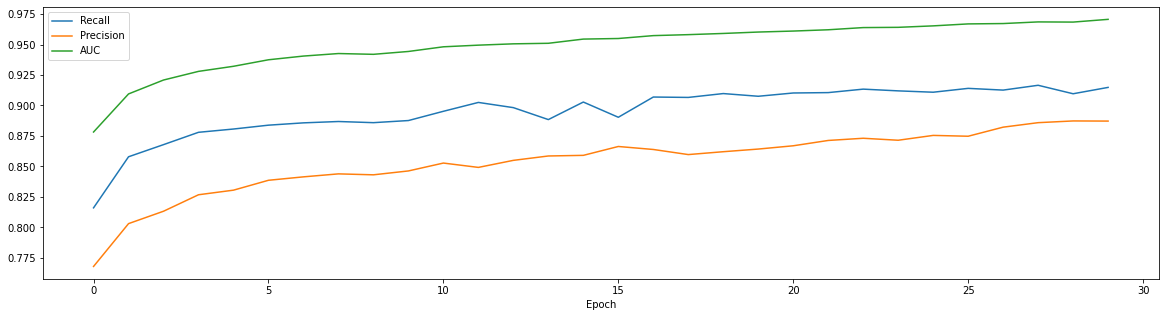

In [ ]:
plt.plot(vgg_16_model.history.history['Recall'])
plt.plot(vgg_16_model.history.history['Precision'])
plt.plot(vgg_16_model.history.history['AUC'])
plt.legend(("Recall","Precision","AUC"))
plt.xlabel('Epoch')

**Resnet 50 Model**

In [ ]:
def identity_block(X, f, filters):
    F1, F2, F3 = filters
    
    X_shortcut = X
    
    X = Conv1D(filters = F1, kernel_size = 1, activation='relu', strides = 1, padding = 'valid')(X)
    X = BatchNormalization()(X)
    
    X = Conv1D(filters = F2, kernel_size = f, activation='relu', strides = 1, padding = 'same')(X)
    X = BatchNormalization()(X)

    X = Conv1D(filters = F3, kernel_size = 1, activation='relu', strides = 1, padding = 'valid')(X)
    X = BatchNormalization()(X)

    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X

def convolutional_block(X, f, filters, s = 2):
    F1, F2, F3 = filters
    
    X_shortcut = X

    X = Conv1D(F1, 1, activation='relu', strides = s)(X)
    X = BatchNormalization()(X)
    
    X = Conv1D(F2, f, activation='relu', strides = 1,padding = 'same')(X)
    X = BatchNormalization()(X)

    X = Conv1D(F3, 1, strides = 1)(X)
    X = BatchNormalization()(X)

    X_shortcut = Conv1D(F3, 1, strides = s)(X_shortcut)
    X_shortcut = BatchNormalization()(X_shortcut)
    
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X

def ResNet50(input_shape):
    
    X_input = Input(input_shape)

    X = ZeroPadding1D(3)(X_input)
    
    X = Conv1D(64, 7, strides = 2)(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = MaxPool1D(pool_size=2, strides=2, padding='same')(X)

    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

    X = convolutional_block(X, f = 3, filters = [128,128,512], s = 2)
    X = identity_block(X, 3, [128,128,512])
    X = identity_block(X, 3, [128,128,512])
    X = identity_block(X, 3, [128,128,512])

    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    X = MaxPool1D(pool_size=2, strides=2, padding='same')(X)
    
    X = GlobalAveragePooling1D()(X)
    X = Dense(1,activation='sigmoid')(X)
    
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [ ]:
resNet50_model = ResNet50(input_shape = (1000,12))

In [ ]:
resNet50_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])

In [ ]:
resNet50_model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1000, 12)]   0           []                               
                                                                                                  
 zero_padding1d (ZeroPadding1D)  (None, 1006, 12)    0           ['input_1[0][0]']                
                                                                                                  
 conv1d_20 (Conv1D)             (None, 500, 64)      5440        ['zero_padding1d[0][0]']         
                                                                                                  
 batch_normalization_20 (BatchN  (None, 500, 64)     256         ['conv1d_20[0][0]']              
 ormalization)                                                                             

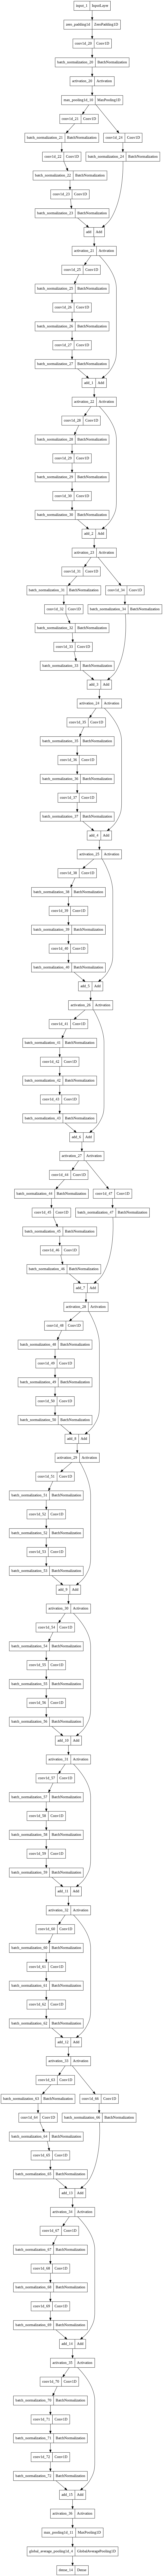

In [ ]:
plot_model(resNet50_model)

In [ ]:
batchsize = 16
resNet50_model.fit(x=signal, y=target, batch_size=batchsize, epochs=30, verbose='auto', callbacks=None, validation_split=0.2, validation_data=(v_signal,v_target), shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None)

Epoch 1/30
872/872 [==============================] - 86s 84ms/step - loss: 0.6533 - accuracy: 0.7140 - Recall: 0.6930 - Precision: 0.6818 - AUC: 0.7831 - val_loss: 0.5731 - val_accuracy: 0.8060 - val_Recall: 0.8873 - val_Precision: 0.6803 - val_AUC: 0.8928
Epoch 2/30
872/872 [==============================] - 71s 82ms/step - loss: 0.4361 - accuracy: 0.8052 - Recall: 0.8050 - Precision: 0.7744 - AUC: 0.8832 - val_loss: 0.7409 - val_accuracy: 0.8389 - val_Recall: 0.8412 - val_Precision: 0.7497 - val_AUC: 0.9150
Epoch 3/30
872/872 [==============================] - 71s 81ms/step - loss: 0.4124 - accuracy: 0.8225 - Recall: 0.8276 - Precision: 0.7909 - AUC: 0.8983 - val_loss: 0.9879 - val_accuracy: 0.8214 - val_Recall: 0.9249 - val_Precision: 0.6916 - val_AUC: 0.9247
Epoch 4/30
872/872 [==============================] - 70s 81ms/step - loss: 0.3917 - accuracy: 0.8342 - Recall: 0.8314 - Precision: 0.8085 - AUC: 0.9075 - val_loss: 0.9077 - val_accuracy: 0.7120 - val_Recall: 0.3224 - val_Prec

Text(0, 0.5, 'Accuracy')

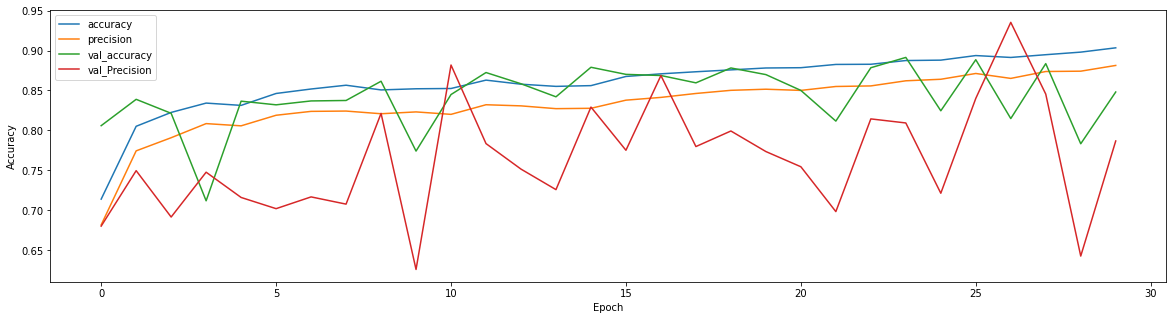

In [ ]:
plt.plot(resNet50_model.history.history['accuracy'])
plt.plot(resNet50_model.history.history['Precision'])
plt.plot(resNet50_model.history.history['val_accuracy'])
plt.plot(resNet50_model.history.history['val_Precision'])
plt.legend(("accuracy","precision","val_accuracy","val_Precision"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

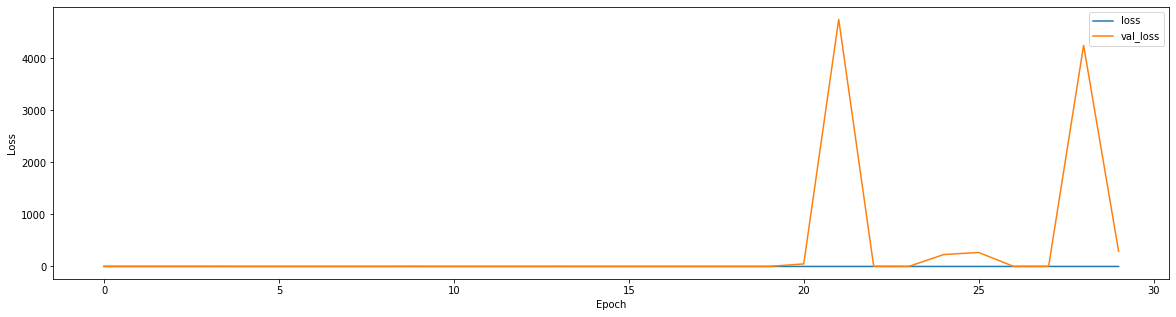

In [ ]:
plt.plot(resNet50_model.history.history['loss'])
plt.plot(resNet50_model.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0.5, 0, 'Epoch')

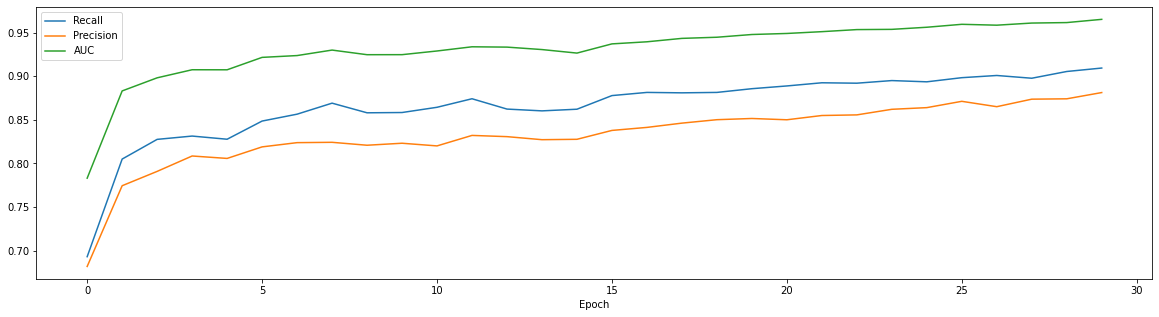

In [ ]:
plt.plot(resNet50_model.history.history['Recall'])
plt.plot(resNet50_model.history.history['Precision'])
plt.plot(resNet50_model.history.history['AUC'])
plt.legend(("Recall","Precision","AUC"))
plt.xlabel('Epoch')

**Inseption Model**

In [ ]:
def inception_block(prev_layer):
    
    conv1=Conv1D(filters = 64, kernel_size = 1, padding = 'same')(prev_layer)
    conv1=BatchNormalization()(conv1)
    conv1=Activation('relu')(conv1)
    
    conv3=Conv1D(filters = 64, kernel_size = 1, padding = 'same')(prev_layer)
    conv3=BatchNormalization()(conv3)
    conv3=Activation('relu')(conv3)
    conv3=Conv1D(filters = 64, kernel_size = 3, padding = 'same')(conv3)
    conv3=BatchNormalization()(conv3)
    conv3=Activation('relu')(conv3)
    
    conv5=Conv1D(filters = 64, kernel_size = 1, padding = 'same')(prev_layer)
    conv5=BatchNormalization()(conv5)
    conv5=Activation('relu')(conv5)
    conv5=Conv1D(filters = 64, kernel_size = 5, padding = 'same')(conv5)
    conv5=BatchNormalization()(conv5)
    conv5=Activation('relu')(conv5)
    
    pool= MaxPool1D(pool_size=3, strides=1, padding='same')(prev_layer)
    convmax=Conv1D(filters = 64, kernel_size = 1, padding = 'same')(pool)
    convmax=BatchNormalization()(convmax)
    convmax=Activation('relu')(convmax)
    
    layer_out = concatenate([conv1, conv3, conv5, convmax], axis=1)
    
    return layer_out

def inception_model(input_shape):
    X_input=Input(input_shape)
    
    X = ZeroPadding1D(3)(X_input)
    
    X = Conv1D(filters = 64, kernel_size = 7, padding = 'same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = MaxPool1D(pool_size=3, strides=2, padding='same')(X)
    
    X = Conv1D(filters = 64, kernel_size = 1, padding = 'same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    X = inception_block(X)
    X = inception_block(X)
    
    X = MaxPool1D(pool_size=7, strides=2, padding='same')(X)
    
    X = GlobalAveragePooling1D()(X)
    X = Dense(1,activation='sigmoid')(X)
    
    model = Model(inputs = X_input, outputs = X, name='Inception')
    
    return model

In [ ]:
inception_model = inception_model(input_shape = (1000,12))

In [ ]:
inception_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])

In [ ]:
inception_model.summary()

Model: "Inception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1000, 12)]   0           []                               
                                                                                                  
 zero_padding1d_1 (ZeroPadding1  (None, 1006, 12)    0           ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1d_73 (Conv1D)             (None, 1006, 64)     5440        ['zero_padding1d_1[0][0]']       
                                                                                                  
 batch_normalization_73 (BatchN  (None, 1006, 64)    256         ['conv1d_73[0][0]']      

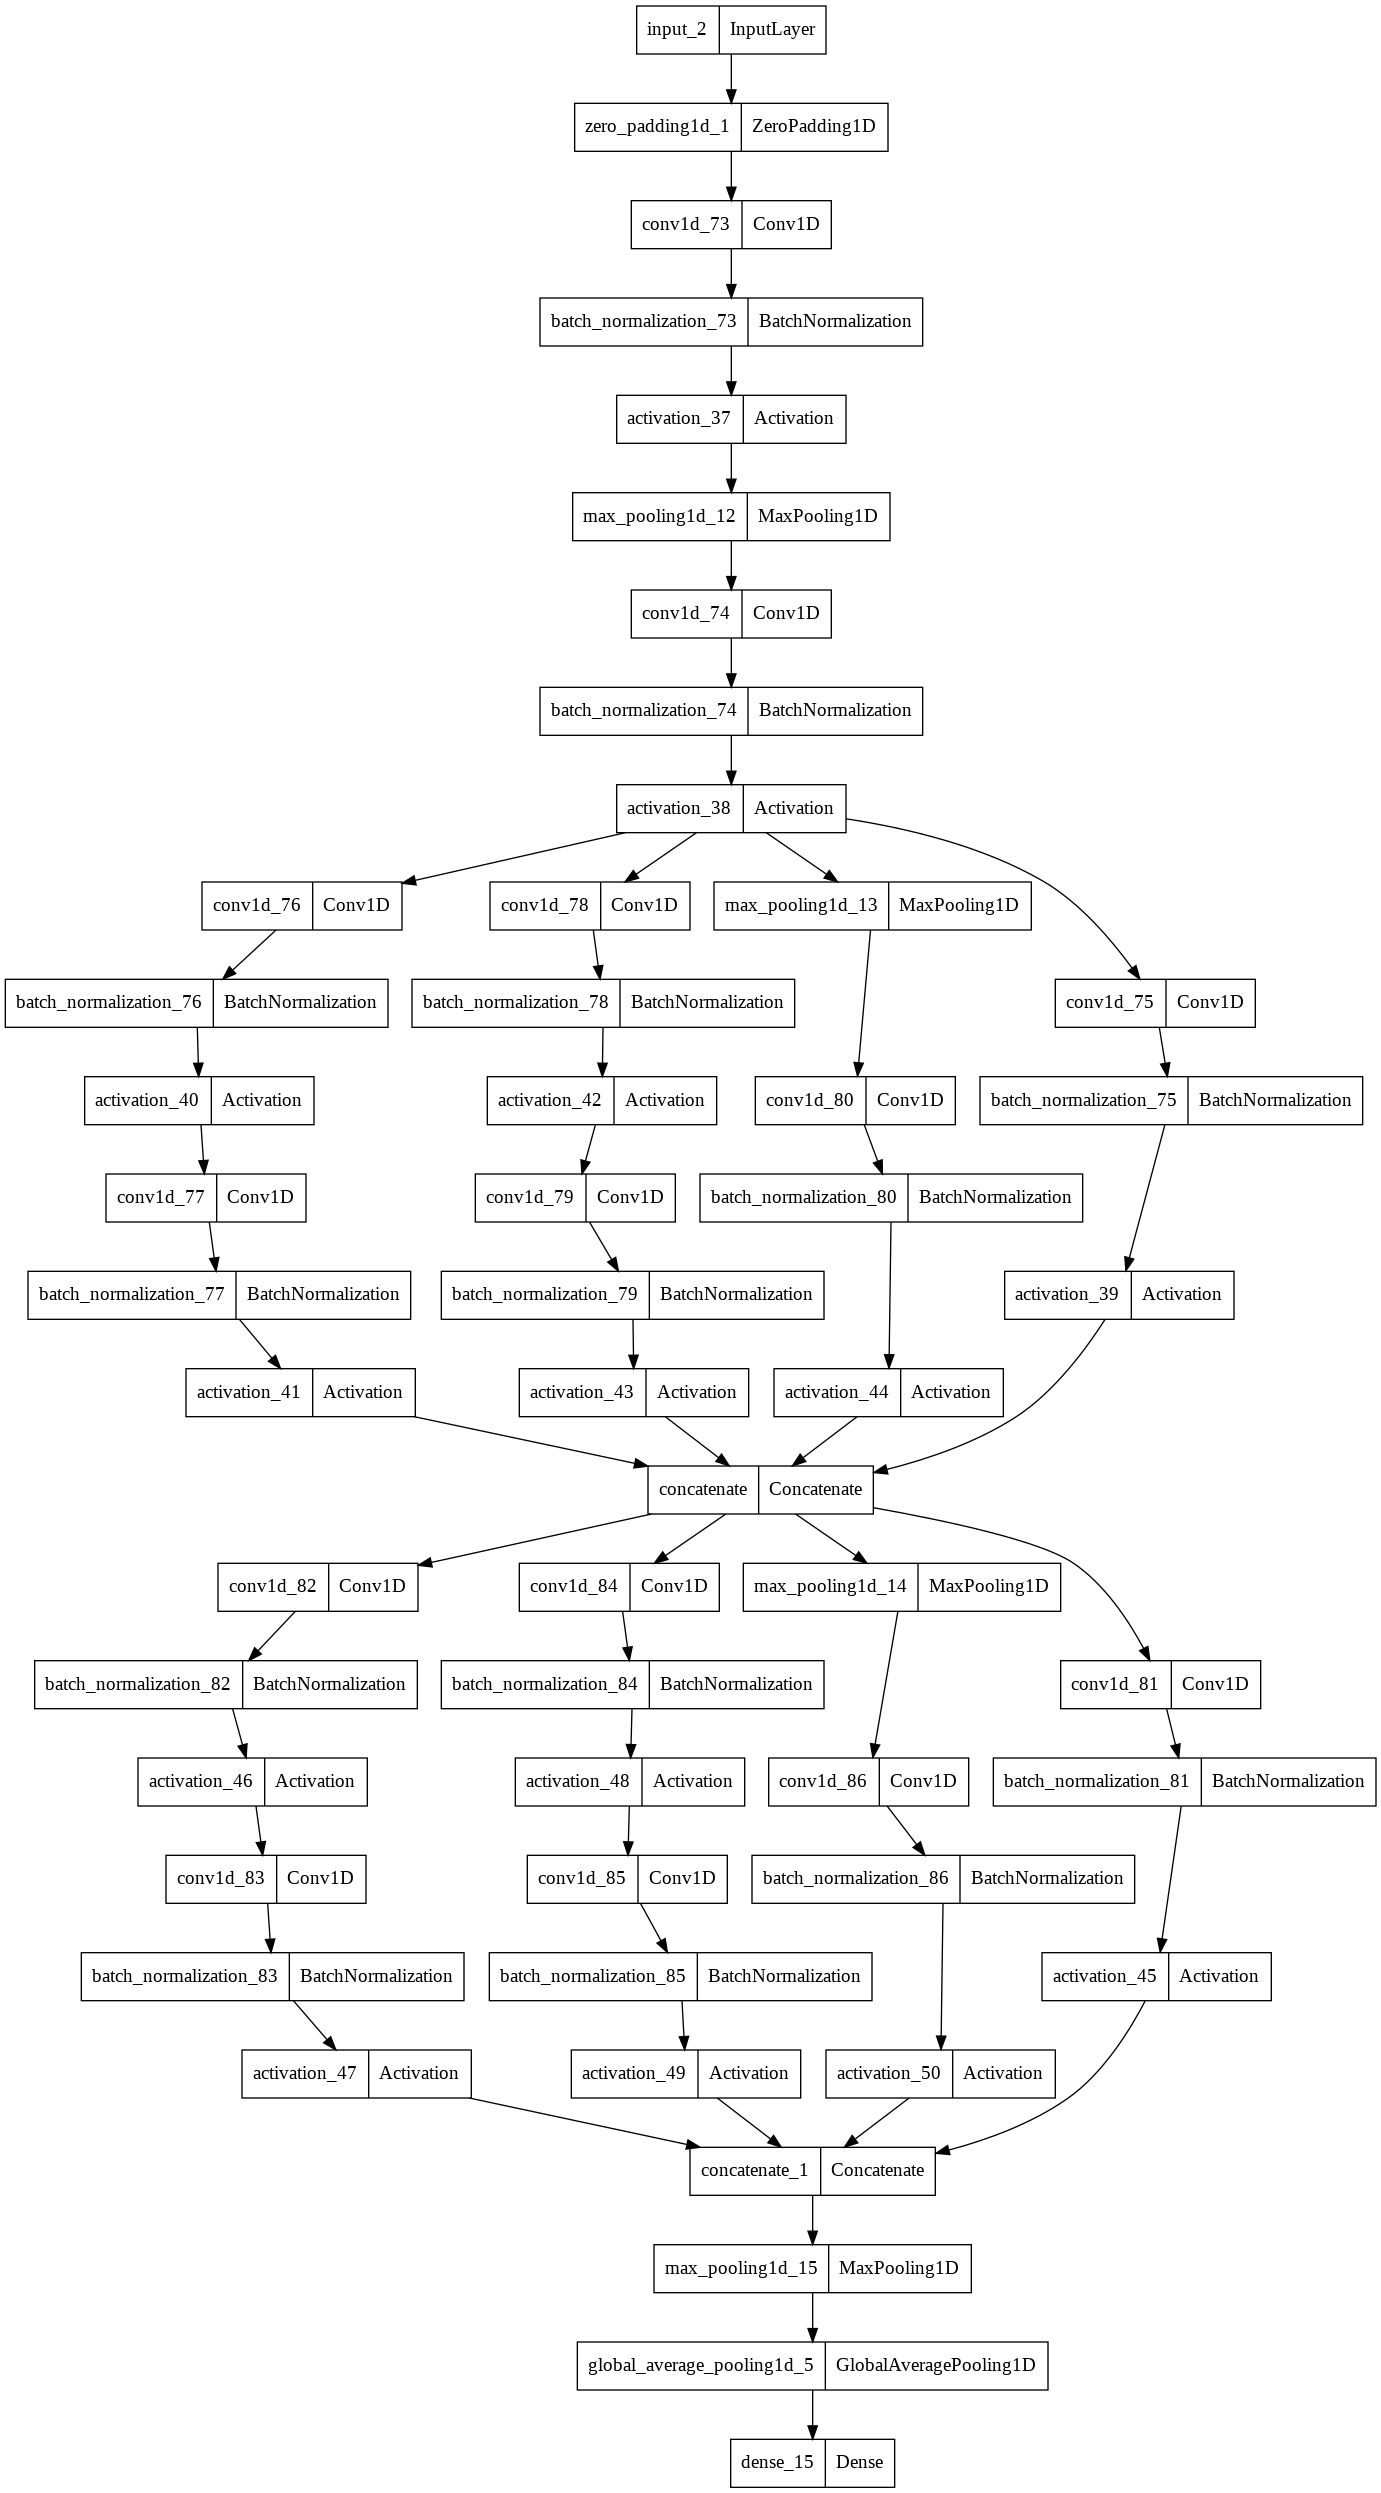

In [ ]:
plot_model(inception_model)

In [ ]:
batchsize = 16
inception_model.fit(x=signal, y=target, batch_size=batchsize, epochs=30, verbose='auto', callbacks=None, validation_split=0.2, validation_data=(v_signal,v_target), shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None)

Epoch 1/30
872/872 [==============================] - 36s 37ms/step - loss: 0.3912 - accuracy: 0.8184 - Recall: 0.8131 - Precision: 0.7922 - AUC: 0.9026 - val_loss: 0.3394 - val_accuracy: 0.8567 - val_Recall: 0.7340 - val_Precision: 0.8543 - val_AUC: 0.9336
Epoch 2/30
872/872 [==============================] - 31s 36ms/step - loss: 0.3388 - accuracy: 0.8530 - Recall: 0.8597 - Precision: 0.8239 - AUC: 0.9277 - val_loss: 0.3127 - val_accuracy: 0.8647 - val_Recall: 0.8826 - val_Precision: 0.7779 - val_AUC: 0.9420
Epoch 3/30
872/872 [==============================] - 31s 36ms/step - loss: 0.3219 - accuracy: 0.8589 - Recall: 0.8678 - Precision: 0.8291 - AUC: 0.9347 - val_loss: 0.3130 - val_accuracy: 0.8693 - val_Recall: 0.7778 - val_Precision: 0.8525 - val_AUC: 0.9430
Epoch 4/30
872/872 [==============================] - 31s 35ms/step - loss: 0.3116 - accuracy: 0.8668 - Recall: 0.8750 - Precision: 0.8385 - AUC: 0.9386 - val_loss: 0.2892 - val_accuracy: 0.8822 - val_Recall: 0.7809 - val_Prec

Text(0, 0.5, 'Accuracy')

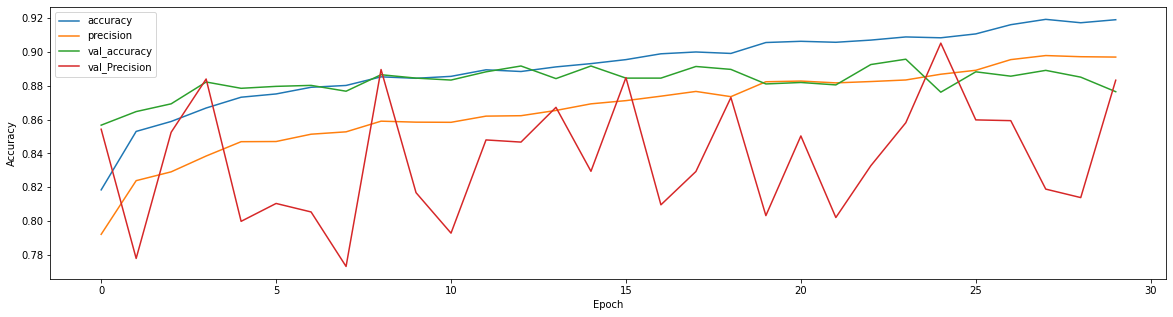

In [ ]:
plt.plot(inception_model.history.history['accuracy'])
plt.plot(inception_model.history.history['Precision'])
plt.plot(inception_model.history.history['val_accuracy'])
plt.plot(inception_model.history.history['val_Precision'])
plt.legend(("accuracy","precision","val_accuracy","val_Precision"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

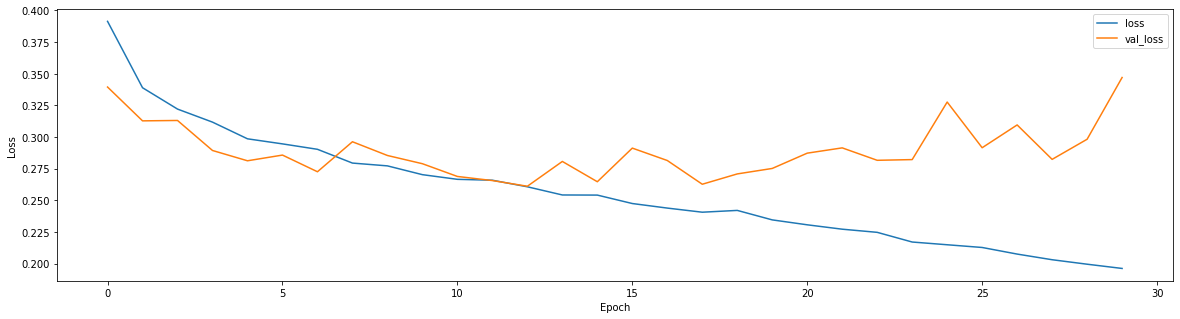

In [ ]:
plt.plot(inception_model.history.history['loss'])
plt.plot(inception_model.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0.5, 0, 'Epoch')

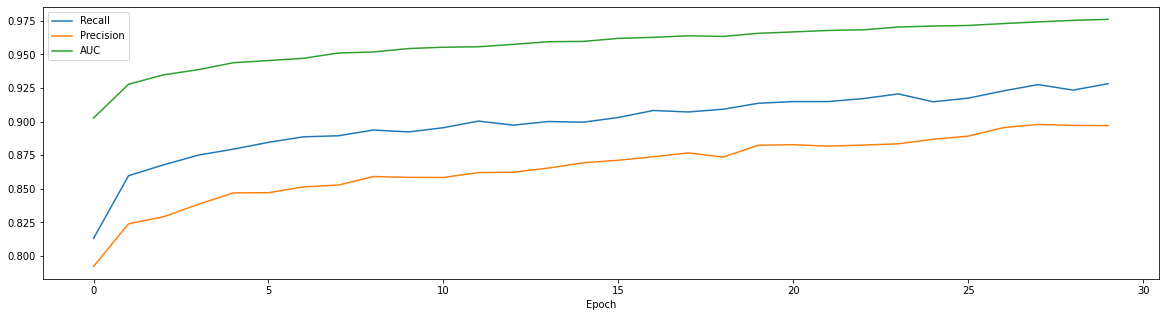

In [ ]:
plt.plot(inception_model.history.history['Recall'])
plt.plot(inception_model.history.history['Precision'])
plt.plot(inception_model.history.history['AUC'])
plt.legend(("Recall","Precision","AUC"))
plt.xlabel('Epoch')

**RNN Models**

**LSTM Model**

In [ ]:
lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(1000,12), return_sequences=True))
lstm_model.add(LSTM(64))
lstm_model.add(Dense(32, activation = 'relu'))
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(1, activation = 'sigmoid'))

In [ ]:
 lstm_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])

In [ ]:
lstm_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1000, 64)          19712     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_16 (Dense)            (None, 32)                2080      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_17 (Dense)            (None, 1)                 33        
                                                                 
Total params: 54,849
Trainable params: 54,849
Non-trainable params: 0
_________________________________________________________________


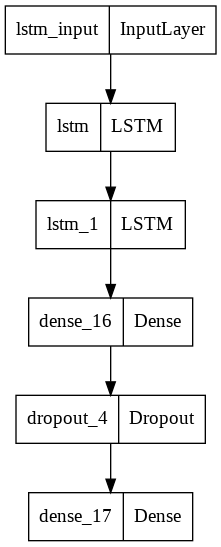

In [ ]:
plot_model(lstm_model)

In [ ]:
batchsize = 16
lstm_model.fit(x=signal, y=target, batch_size=batchsize, epochs=30, verbose='auto', callbacks=None, validation_split=0.2, validation_data=(v_signal,v_target), shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None)

Epoch 1/30
872/872 [==============================] - 63s 68ms/step - loss: 0.6875 - accuracy: 0.5476 - Recall: 0.0769 - Precision: 0.5089 - AUC: 0.5219 - val_loss: 0.6808 - val_accuracy: 0.6340 - val_Recall: 7.8247e-04 - val_Precision: 1.0000 - val_AUC: 0.5069
Epoch 2/30
872/872 [==============================] - 57s 66ms/step - loss: 0.6902 - accuracy: 0.5459 - Recall: 0.0051 - Precision: 0.4507 - AUC: 0.5055 - val_loss: 0.6793 - val_accuracy: 0.6337 - val_Recall: 0.0000e+00 - val_Precision: 0.0000e+00 - val_AUC: 0.5002
Epoch 3/30
872/872 [==============================] - 57s 66ms/step - loss: 0.6892 - accuracy: 0.5464 - Recall: 0.0000e+00 - Precision: 0.0000e+00 - AUC: 0.5031 - val_loss: 0.6670 - val_accuracy: 0.6337 - val_Recall: 0.0000e+00 - val_Precision: 0.0000e+00 - val_AUC: 0.5015
Epoch 4/30
872/872 [==============================] - 57s 66ms/step - loss: 0.6891 - accuracy: 0.5464 - Recall: 0.0000e+00 - Precision: 0.0000e+00 - AUC: 0.5012 - val_loss: 0.6736 - val_accuracy: 0.

Text(0, 0.5, 'Accuracy')

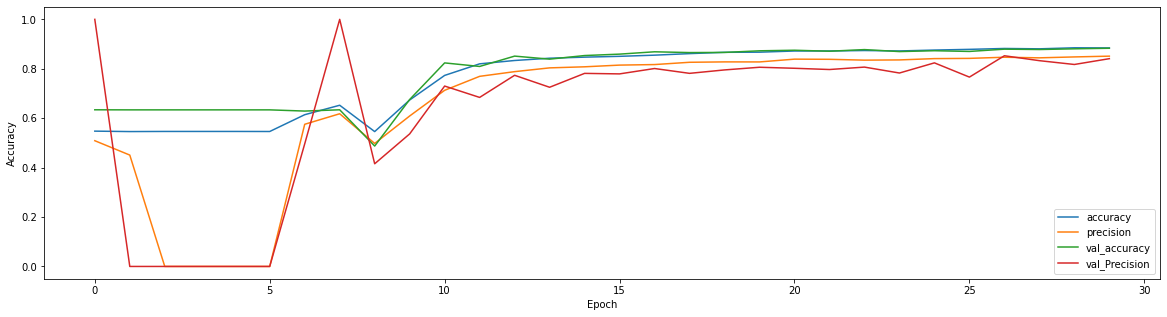

In [ ]:
plt.plot(lstm_model.history.history['accuracy'])
plt.plot(lstm_model.history.history['Precision'])
plt.plot(lstm_model.history.history['val_accuracy'])
plt.plot(lstm_model.history.history['val_Precision'])
plt.legend(("accuracy","precision","val_accuracy","val_Precision"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

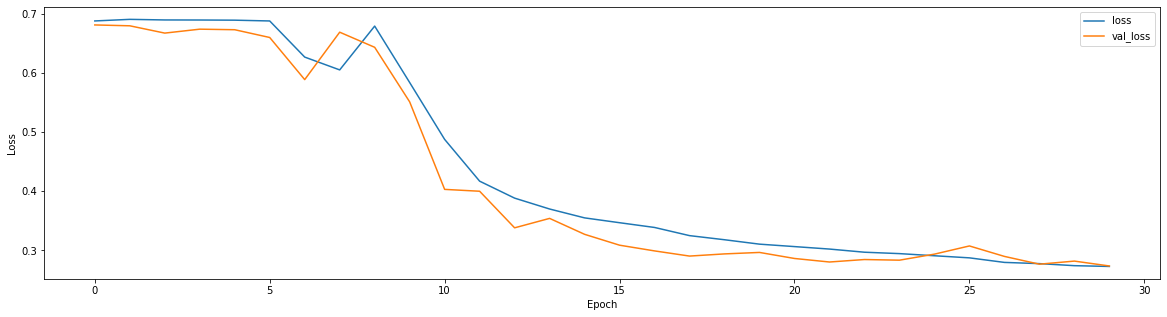

In [ ]:
plt.plot(lstm_model.history.history['loss'])
plt.plot(lstm_model.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0.5, 0, 'Epoch')

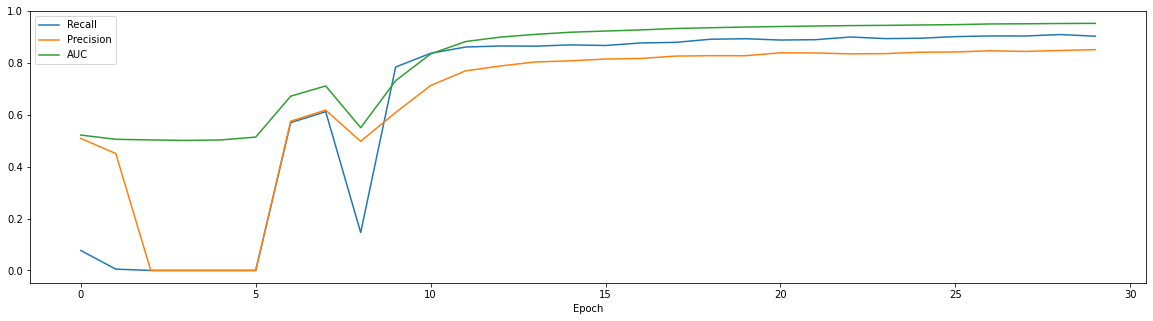

In [ ]:
plt.plot(lstm_model.history.history['Recall'])
plt.plot(lstm_model.history.history['Precision'])
plt.plot(lstm_model.history.history['AUC'])
plt.legend(("Recall","Precision","AUC"))
plt.xlabel('Epoch')

In [ ]:
#ann_model = Sequential()
#ann_model.add(Dense(50, activation='relu'))
#ann_model.add(Dense(50, activation='relu'))
#ann_model.add(Dense(50, activation='relu'))
#ann_model.add(GlobalAveragePooling1D())
#ann_model.add(Dense(1, activation='sigmoid'))

**CNN+LSTM**

In [ ]:
convlstm_model = Sequential()
convlstm_model.add(Input((10,100,12)))
convlstm_model.add(ConvLSTM1D(64, kernel_size=2, strides=1, padding = 'same',return_sequences=True))
convlstm_model.add(BatchNormalization())

convlstm_model.add(ConvLSTM1D(64,padding = 'same', kernel_size=3))
convlstm_model.add(Dense(32, activation = 'relu'))
convlstm_model.add(Dropout(0.3))
convlstm_model.add(Dense(1, activation = 'sigmoid'))

In [ ]:
convlstm_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])

In [ ]:
convlstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm1d (ConvLSTM1D)    (None, 10, 100, 64)       39168     
                                                                 
 batch_normalization (BatchN  (None, 10, 100, 64)      256       
 ormalization)                                                   
                                                                 
 conv_lstm1d_1 (ConvLSTM1D)  (None, 100, 64)           98560     
                                                                 
 dense (Dense)               (None, 100, 32)           2080      
                                                                 
 dropout (Dropout)           (None, 100, 32)           0         
                                                                 
 dense_1 (Dense)             (None, 100, 1)            33        
                                                        

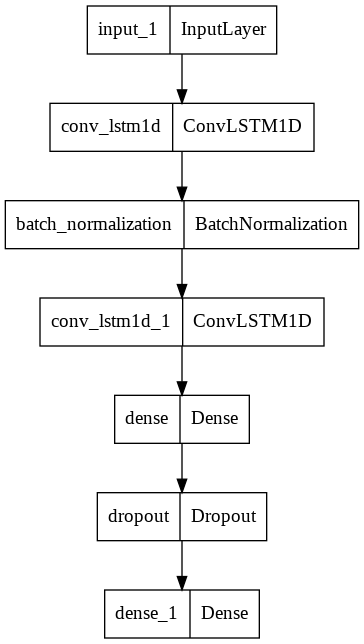

In [ ]:
plot_model(convlstm_model)

In [ ]:
batchsize = 32
convlstm_model.fit(x=newsignal, y=target, batch_size=batchsize, epochs=50, verbose='auto', callbacks=None, validation_split=0.2, validation_data=(newv_signal,v_target), shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None)

Epoch 1/50


ValueError: ignored

In [ ]:
plt.plot(convlstm_model.history.history['accuracy'])
plt.plot(convlstm_model.history.history['Precision'])
plt.plot(convlstm_model.history.history['val_accuracy'])
plt.plot(convlstm_model.history.history['val_Precision'])
plt.legend(("accuracy","precision","val_accuracy","val_Precision"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [ ]:
plt.plot(convlstm_model.history.history['loss'])
plt.plot(convlstm_model.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [ ]:
plt.plot(convlstm_model.history.history['Recall'])
plt.plot(convlstm_model.history.history['Precision'])
plt.plot(convlstm_model.history.history['AUC'])
plt.legend(("Recall","Precision","AUC"))
plt.xlabel('Epoch')

In [ ]:
input_layer = Input(shape=(1000,12))
conv1 = Conv1D(filters=32,
kernel_size=8,
strides=1,
activation='relu')(input_layer)
pool1 = MaxPool1D(pool_size=4)(conv1)
lstm1 = LSTM(64)(pool1)
output_layer = Dense(1, activation='sigmoid')(lstm1)
model = Model(inputs=input_layer, outputs=output_layer)

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1000, 12)]        0         
                                                                 
 conv1d_1 (Conv1D)           (None, 993, 32)           3104      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 248, 32)          0         
 1D)                                                             
                                                                 
 lstm_1 (LSTM)               (None, 64)                24832     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 28,001
Trainable params: 28,001
Non-trainable params: 0
_______________________________________________________

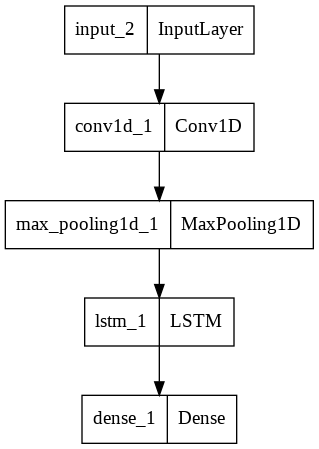

In [ ]:
plot_model(model)

In [ ]:
#tf.config.run_functions_eagerly(True)

In [ ]:
batchsize = 32
model.fit(x=signal, y=target, batch_size=batchsize, epochs=50, verbose='auto', callbacks=None, validation_split=0.2, validation_data=(v_signal,v_target), shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None)

Epoch 1/50
436/436 [==============================] - 10s 17ms/step - loss: 0.6217 - accuracy: 0.6358 - Recall: 0.4606 - Precision: 0.6360 - AUC: 0.7017 - val_loss: 0.5066 - val_accuracy: 0.7911 - val_Recall: 0.7793 - val_Precision: 0.6902 - val_AUC: 0.8554
Epoch 2/50
436/436 [==============================] - 6s 15ms/step - loss: 0.4947 - accuracy: 0.7698 - Recall: 0.8118 - Precision: 0.7177 - AUC: 0.8356 - val_loss: 0.5676 - val_accuracy: 0.6675 - val_Recall: 0.9624 - val_Precision: 0.5252 - val_AUC: 0.8643
Epoch 3/50
436/436 [==============================] - 7s 17ms/step - loss: 0.4116 - accuracy: 0.8152 - Recall: 0.8369 - Precision: 0.7741 - AUC: 0.8899 - val_loss: 0.3796 - val_accuracy: 0.8249 - val_Recall: 0.8944 - val_Precision: 0.7060 - val_AUC: 0.9142
Epoch 4/50
436/436 [==============================] - 6s 15ms/step - loss: 0.3861 - accuracy: 0.8321 - Recall: 0.8343 - Precision: 0.8032 - AUC: 0.9036 - val_loss: 0.3435 - val_accuracy: 0.8544 - val_Recall: 0.8106 - val_Precisi

Text(0, 0.5, 'Accuracy')

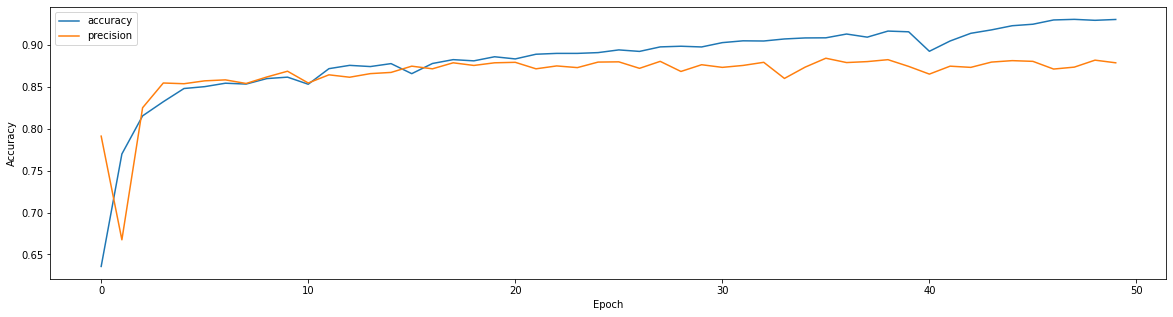

In [ ]:
plt.plot(model.history.history['accuracy'])
#plt.plot(model.history.history['Precision'])
plt.plot(model.history.history['val_accuracy'])
#plt.plot(model.history.history['val_Precision'])
plt.legend(("accuracy","precision","val_accuracy","val_Precision"))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

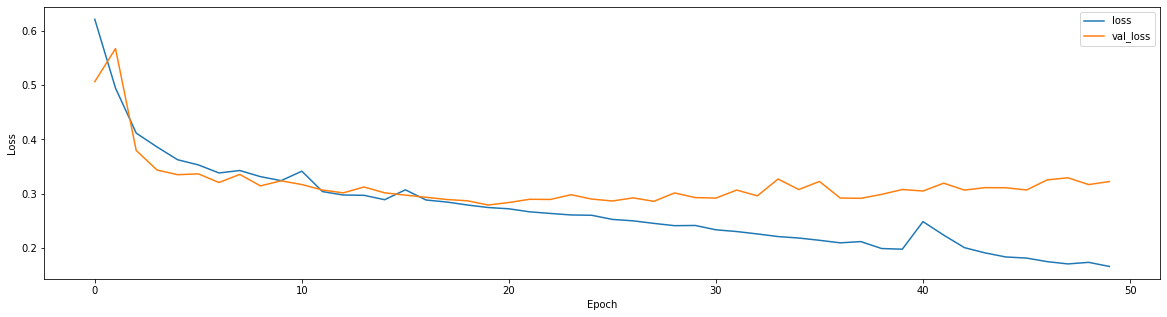

In [ ]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.legend(("loss","val_loss"))
plt.xlabel('Epoch')
plt.ylabel('Loss')